# Problem

_You’re thinking about doing a backpacking trip through Rainier National Park but there’s one big concern; that’s Samsquanch territory! After thinking it over for a moment you realize you have one big advantage; Samsquanch’s broad shoulders make it more difficult to navigate dense trees while your small, nerdy frame can fit quite easily. In order to make sure you have a chance to escape, you want to make sure the forest you’re hiking through has sufficient tree density._

_Let’s model our forest as a 10x10 square. The top will be the entrance and the bottom will be the exit. For simplicity, we will assume the sides are impassable barriers. Each tree will be modeled by a point and Samsquanch will be modeled by a circle of radius 1. Trees will be distributed uniformly in the 10x10 square. Let’s further assume that Samsquanch can’t fit between any two trees that are less than 2R apart. We need to figure out what density the trees need to be in order for you to evade Samsquanch._

_But before tackling this rather tricky probability problem, let’s start with a (hopefully) simpler problem:_

_Given a randomly sampled forest, what’s the most efficient algorithm you can find to determine if Samsquanch can traverse the forest?_

# Solution

We first need to observe that Samsquanch can only fit between two trees if the distance between them is at least 2. If there's exists a continuous sequnce of tress that spans from one side to the other, then Samsquance can't fit. Otherwise, he can. This means that we can model the forest as a graph where each tree is a node and two nodes are connected by an edge if the distance between the trees is less than 2. We can then use a graph traversal algorithm to determine if there's a path from the top to the bottom.

For the purposes of this problem, using a brute force method to calculate the distance between each pair of trees is sufficient. We can then use a depth-first search to determine if there's a path from the top to the bottom.

If we wanted to be more optimal, we could use KD-trees and an A* search to find the shortest path, but I'm not quite feeling up to that this time :)

## Complexity

The brute force method to calculate the distance between each pair of trees is O(n^2) where n is the number of trees. The depth-first search is O(n) where n is the number of trees. Thus, the overall complexity is O(n^2).

Below is the implementation of the algorithm.

In [80]:
import numpy as np

def generate_forest(num_trees, grid_size=10):
    """
    Generates a list of randomly distributed trees in a 10x10 grid.
    
    Parameters:
    num_trees (int): Number of trees to generate.
    grid_size (int): Size of the grid (default 10x10).
    
    Returns:
    np.ndarray: Array of shape (num_trees, 2) with x, y coordinates of the trees.
    """
    tree_positions = np.random.rand(num_trees, 2) * grid_size
    return tree_positions

def display_forest(tree_positions):
    """
    displays a plot of the forest grid with the trees. Includes a translucent circle of radius 1 around each tree.
    Each tree is labeled by its index.
    
    Parameters:
    tree_positions (np.ndarray): Array of shape (num_trees, 2) with x, y coordinates of the trees.
    """
    import matplotlib.pyplot as plt
    for i, tree in enumerate(tree_positions):
        plt.scatter(tree[0], tree[1], c='green', s=100)
        circle = plt.Circle((tree[0], tree[1]), 1, color='green', alpha=0.2)
        plt.gca().add_artist(circle)
        plt.text(tree[0], tree[1], str(i), ha='center', va='center')
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

In [69]:
def distance_graph(tree_positions):
    """
    Contructs a graph of the distances between trees only if the distance is less than 2

    Parameters:
    tree_positions (np.ndarray): Array of shape (num_trees, 2) with x, y coordinates of the trees.

    Returns:
    np.ndarray: Adjacency matrix of the graph.
    """
    num_trees = tree_positions.shape[0]
    adjacency_matrix = np.zeros((num_trees, num_trees))
    for i in range(num_trees):
        for j in range(i+1, num_trees):
            distance = np.linalg.norm(tree_positions[i] - tree_positions[j])
            if distance < 2:
                adjacency_matrix[i, j] = 1
                adjacency_matrix[j, i] = 1
    return adjacency_matrix

def get_graph_heads(tree_positions):
    """
    Returns the trees that are within length 2 of the left side
    
    Parameters:
    tree_positions (np.ndarray): Array of shape (num_trees, 2) with x, y coordinates of the trees.
    
    Returns:
    list: List of indices of the trees that are within length 2 of the left side.
    """
    num_trees = tree_positions.shape[0]
    heads = []
    for i in range(num_trees):
        if tree_positions[i][0] < 2:
            heads.append(i)
    return heads

def get_graph_tails(tree_positions):
    """
    Returns the trees that are within length 2 of the right side
    
    Parameters:
    tree_positions (np.ndarray): Array of shape (num_trees, 2) with x, y coordinates of the trees.
    
    Returns:
    list: List of indices of the trees that are within length 2 of the right side.
    """
    num_trees = tree_positions.shape[0]
    tails = []
    for i in range(num_trees):
        if tree_positions[i][0] > 8:
            tails.append(i)
    return tails

def dfs(graph, start, ends, visited=None):
    """
    Depth-first search algorithm for finding paths in a graph.

    Parameters:
    graph (np.ndarray): Adjacency matrix of the graph.
    start (int): Index of the starting node.
    ends (list): List of indices of the ending nodes.
    visited (list): List of visited nodes (default None).

    Returns:
    list: List of paths from the starting node to the ending nodes.
    """
    if visited is None:
        visited = []
    visited = visited + [start]
    paths = []
    if start in ends:
        return [visited]
    for i in range(len(graph[start])):
        if graph[start][i] == 1 and i not in visited:
            new_paths = dfs(graph, i, ends, visited)
            for new_path in new_paths:
                paths.append(new_path)
    return paths

def dfs_is_path(graph, start, ends, visited=None):
    """
    Depth-first search algorithm for finding paths in a graph. Stops once a path is found.

    Parameters:
    graph (np.ndarray): Adjacency matrix of the graph.
    start (int): Index of the starting node.
    ends (list): List of indices of the ending nodes.
    visited (list): List of visited nodes (default None).

    Returns:
    path (list): List of nodes in the path from the starting node to the ending nodes, including the starting and ending nodes.
    """
    if visited is None:
        visited = []
    visited = visited + [start]
    if start in ends:
        return visited
    for i in range(len(graph[start])):
        if graph[start][i] == 1 and i not in visited:
            path = dfs_is_path(graph, i, ends, visited)
            if path:
                return path
    return None

def find_a_path(tree_positions):
    """
    Returns true once DFS finds a single path from one side to the other.

    Parameters:
    tree_positions (np.ndarray): Array of shape (num_trees, 2) with x, y coordinates of the trees.

    Returns:
    bool: True if there is a path from the left side to the right side.
    """
    graph = distance_graph(tree_positions)
    heads = get_graph_heads(tree_positions)
    tails = get_graph_tails(tree_positions)
    for head in heads:
        path = dfs_is_path(graph, head, tails)
        if path:
            return [path]
    return False
    
def find_paths(tree_positions):
    """
    Finds all paths from the left side to the right side of the forest.
    
    Parameters:
    tree_positions (np.ndarray): Array of shape (num_trees, 2) with x, y coordinates of the trees.
    
    Returns:
    list: List of paths from the left side to the right side.
    """
    graph = distance_graph(tree_positions)
    heads = get_graph_heads(tree_positions)
    tails = get_graph_tails(tree_positions)
    paths = []
    for head in heads:
        paths += dfs(graph, head, tails)
    return paths

In [66]:
def display_forest_w_path(tree_positions, paths):
    """
    displays a plot of the forest grid with the trees. Includes a translucent circle of radius 1 around each tree.
    Each tree is labeled by its index. Include the paths from the left side to the right side.
    
    Parameters:
    tree_positions (np.ndarray): Array of shape (num_trees, 2) with x, y coordinates of the trees.
    """
    import matplotlib.pyplot as plt
    for i, tree in enumerate(tree_positions):
        plt.scatter(tree[0], tree[1], c='green', s=100)
        circle = plt.Circle((tree[0], tree[1]), 1, color='green', alpha=0.2)
        plt.gca().add_artist(circle)
        plt.text(tree[0], tree[1], str(i), ha='center', va='center')
    for path in paths:
        path = np.array([tree_positions[i] for i in path])
        plt.plot(path[:, 0], path[:, 1], c='blue')
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

## Try running these below!

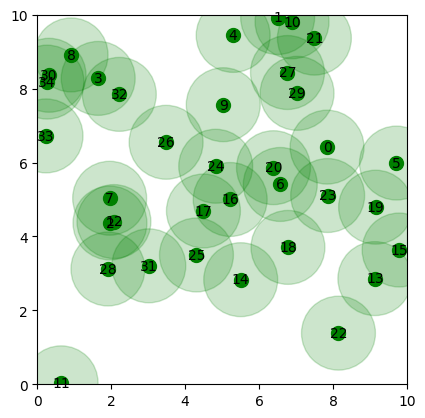

In [78]:
forest = generate_forest(35)
display_forest(forest)

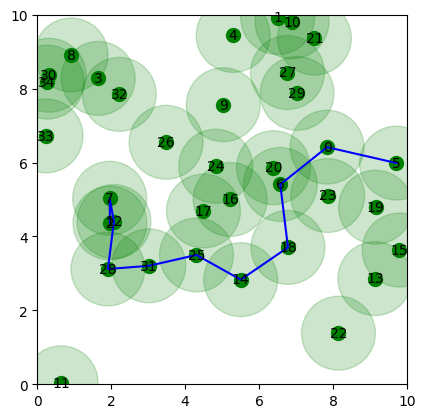

In [79]:
# The plot below shows one of the possible paths of trees that would block Samsquanch from getting to the other side.

paths = find_a_path(forest)
if paths:
    display_forest_w_path(forest, paths)
else:
    print("No path found.")